In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

from gans import ControllableGAN, CelebADataModule
from gans.models.ControllableGAN import get_noise, calculate_updated_noise, get_score

In [2]:
logger = TensorBoardLogger("logs", name = "ControllableGAN")

celeba = CelebADataModule(batch_size=128)
model = ControllableGAN(pretrained=True)

opt = torch.optim.Adam(model.classifier.parameters(), lr=0.01)

# trainer = Trainer(
#     accelerator="auto",
#     devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
#     max_epochs=70,
#     callbacks=[TQDMProgressBar(refresh_rate=20)],
#     logger=logger,
# )
# trainer.fit(model, celeba)

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
    
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
# First generate a bunch of images with the generator
z_dim = 64
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).requires_grad_()
original_classifications = model.classifier(model.generator(noise)).detach()

for i in range(grad_steps):
    opt.zero_grad()
    fake = model.generator(noise)
    fake_image_history += [fake]
    fake_score = get_score(
    model.classifier(fake), 
    original_classifications,
    target_indices,
    other_indices,
    penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

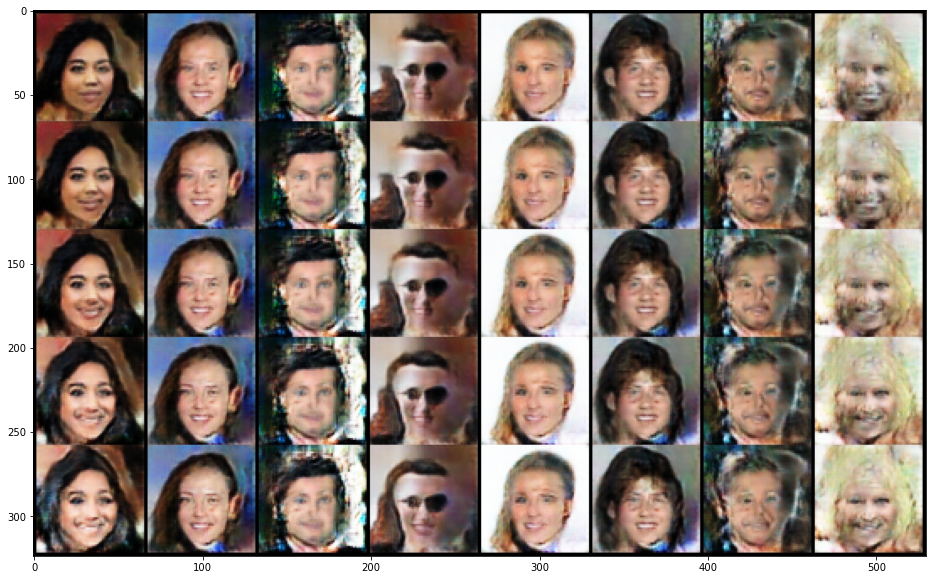

In [5]:
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

In [ ]:
# Start tensorboard.
os.environ['TENSORBOARD_BINARY'] = '/.../anaconda3/envs/pytorch/bin/tensorboard'
%load_ext tensorboard
%tensorboard --logdir gans_logs/ --port 8889 --bind_all